# Best Model Evaluation
**Use conda_tensorflow2_python 3 kernel!**

In [2]:
!pip install wandb scikit-plot -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import json
import yaml
import wandb
import boto3
import base64
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from botocore.exceptions import ClientError
from containers.training_beta.Model import Model 
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_confusion_matrix
from containers.training_beta.DatasetGenerator import DatasetGenerator 

In [4]:
region = 'us-east-2'
metric = 'val_classification_accuracy'
sweep_id = 'rosenblatt/satellite-model-and-orientation/dqcsh4ar'

In [5]:
# TODO: add to a helpers class or something
def get_secret(secret_name, region_name):
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    
    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )
    
    if 'SecretString' in get_secret_value_response:
        secret = get_secret_value_response['SecretString']
        return json.loads(secret)
    else:
        decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
        return decoded_binary_secret

In [6]:
assert wandb.login(key=get_secret("wandb_api_key", region)["wandb_api_key"])
!rm -r wandb

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ec2-user/.netrc


## Download Weights of the Best Model

## Rebuild the Model

In [7]:
# TODO: rebuild the model using config.yaml
config = yaml.load(open('config.yaml'), Loader=yaml.FullLoader)
m = Model(config, translation=False)
model = m.tf_model

94674944/94668760 [==============================] - 5s 0us/step


In [8]:
m.imagenet

1

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
classification (Dense)       (None, 18)                4626  

In [10]:
model.load_weights('model-best.h5')#'best/checkpoint/best_model') # only works with tf 2.3... pip --upgrade tensorflow?

## Download Test Dataset and Perform Predictions

In [11]:
images = []
labels = []
predictions = []
test_ds_gen = DatasetGenerator('validation', multitask=False, distortion=True, evaluate=True) # replace with test and multitask=True
batch_iter = iter(test_ds_gen)

In [ ]:
# TODO: some progress stats would be nice
for _ in range(test_ds_gen.steps):
    batch_images, batch_labels = next(batch_iter)
    images.append(batch_images)
    labels.append(batch_labels)
    batch_pred = model.predict_on_batch(batch_images)
    predictions.append(batch_pred)

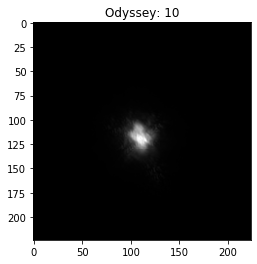

In [24]:
idx = 9
plt.imshow(batch_images[idx])
num = np.argmax(batch_labels[0], 0)[idx]T
plt.title(f'{test_ds_gen.classes[num]}: {num}')
plt.show()

In [26]:
class_labels, distortion_labels = map(list, zip(*labels))
#class_labels, orientation_labels, distortion_labels = map(list, zip(*labels))
class_predictions = predictions

## Plot a Confusion Matrix

In [27]:
%matplotlib inline

In [28]:
# TODO: extract only the classification labels and predictions for the confusion matrix
class_predictions = tf.concat(class_predictions, 0)
class_labels = tf.concat(class_labels, 0)

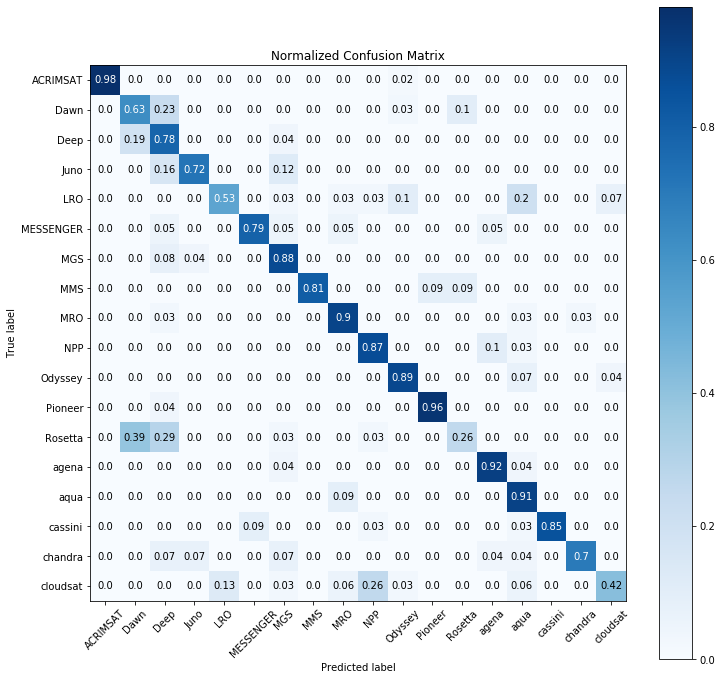

In [29]:
plot_confusion_matrix(
    np.array(test_ds_gen.classes)[np.argmax(class_labels.numpy(), axis=1)], 
    np.array(test_ds_gen.classes)[np.argmax(class_predictions.numpy(), axis=1)], 
    figsize=(12,12),
    labels=test_ds_gen.classes,
    x_tick_rotation=45,
    normalize=True
)
plt.show()

## Orientation Report

In [79]:
# TODO: extract only the classification labels and predictions for the confussion matrix
# orientation_predictions = ...
orientation_labels = tf.concat(orientation_labels,0)
xs, ys, zs = map(list, zip(*orientation_labels))

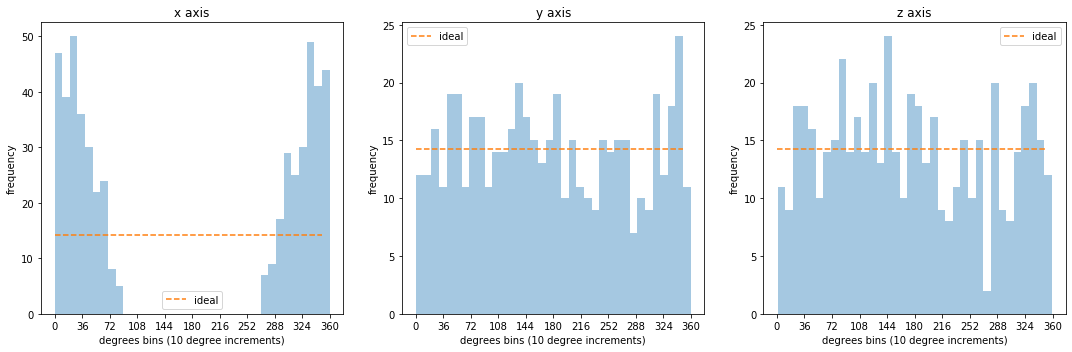

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)
for ax, (k,v) in zip(axes.flatten(), {'x axis':xs, 'y axis':ys, 'z axis':zs}.items()):
    ax.set_title(k)
    sns.distplot(v, bins=36, ax=ax, kde=False)
    ax.set_xlabel('degrees bins (10 degree increments)')
    ax.set_ylabel('frequency')
    ax.set_xticks(np.arange(0,361,36))
    ax.plot(np.arange(0,360,10), [len(v)/36]*36, linestyle='--', label='ideal')
    ax.legend()
fig.tight_layout(w_pad=2.5)
plt.show()

In [83]:
%reset_selective -f "^[x-z]s$"
%reset_selective -f "^orientation_labels$"

## Distortion Report

In [66]:
# TODO: measure how distortion impacted the model
# no clue how to do this with current code...

## Distance Report

In [67]:
# TODO: measure how distortion impacted the model
# no clue how to do this with current code...

### Prediction Demo

In [14]:
def prediction_demo(model, image_batch, label_batch):
    
    predictions = model.predict(image_batch, verbose=1)

    plt.figure(figsize=(10,10))
    
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title('Truth: ' + tf.boolean_mask(classes, label_batch[n])[0].numpy().decode() +
                  '\nPrediction: ' + classes[np.argmax(predictions[n])] +
                  '\nConfidence: ' + str(round(np.max(predictions[n]*100),1)) + '%'
                 )

        plt.axis('off')

    plt.subplots_adjust(top=1.2, right = 1.0)

### Display Demo

In [15]:
demo_image_batch, demo_label_batch, _ = next(iter(val_ds))

16/16 [==============================] - 1s 69ms/sample


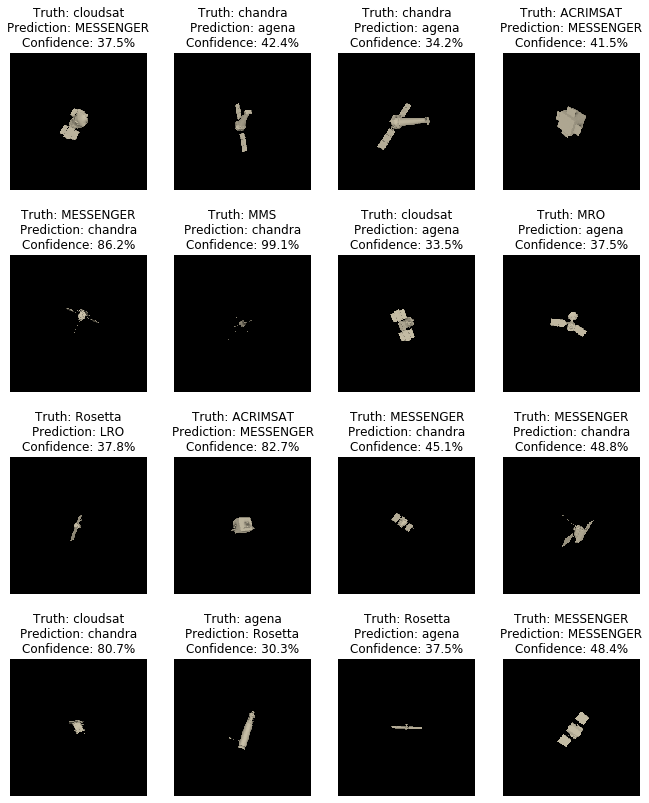

In [17]:
prediction_demo(model, demo_image_batch, demo_label_batch)

In [186]:
def cyclical2degrees(x,y):
    deg = np.degrees(np.arctan(np.divide(x,y)))
    if x == 1 and y == 0:
        return 0
    elif x == 0 and y == 1:
        return 90
    elif x == -1 and y == 0:
        return 180
    elif x == 0 and y == -1:
        return 270
    elif 0 < x <= y:
        # quad 1
        return deg
    elif x < 0 < y:
        # quad 2
         return deg + 180
    elif y <= x < 0:
        # quad 3
        return -1*deg+270
    else:
        #quad 4
        return -1*deg+270

In [188]:
print(cyclical2degrees(1, 0),
      cyclical2degrees(np.sqrt(2)/2, np.sqrt(2)/2),
      cyclical2degrees(1/2, np.sqrt(3)/2),
      cyclical2degrees(0, 1),
      cyclical2degrees(-np.sqrt(2)/2, np.sqrt(2)/2),
      cyclical2degrees(-1/2-np.sqrt(2), np.sqrt(3)/2),
      cyclical2degrees(-1, 0),
      cyclical2degrees(-np.sqrt(2)/2, -np.sqrt(2)/2),
      cyclical2degrees(-np.sqrt(2)/2-np.sqrt(2), -np.sqrt(2)/2+np.sqrt(2)),
      cyclical2degrees(0, -1),
      cyclical2degrees(np.sqrt(2)/2-np.sqrt(2), -np.sqrt(2)/2+np.sqrt(2)),
      cyclical2degrees(np.sqrt(2)/2, -np.sqrt(2)/2))

0 45.0 30.000000000000004 90 135.0 114.3428701752672 180 225.0 108.43494882292201 270 135.0 315.0


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
